In [1]:
library(tidyverse)
library(pheatmap)
library(viridis)
library(stringr)

save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite



In [2]:
save_dir = '../data/processed/fig4_modelling/vocab_sum_final/'


# 1B. motif_to_tissue (pre RNA expression filter)

In [62]:
motif_to_tissue = read.csv(paste0(save_dir, 'motif_to_tissue.csv'),row.names=1)
dim(motif_to_tissue)

[1] 248   6

[1] "../data/processed/fig4_modelling/vocab_sum_final/motif_to_tissue_log.pdf"

pdf 
  2

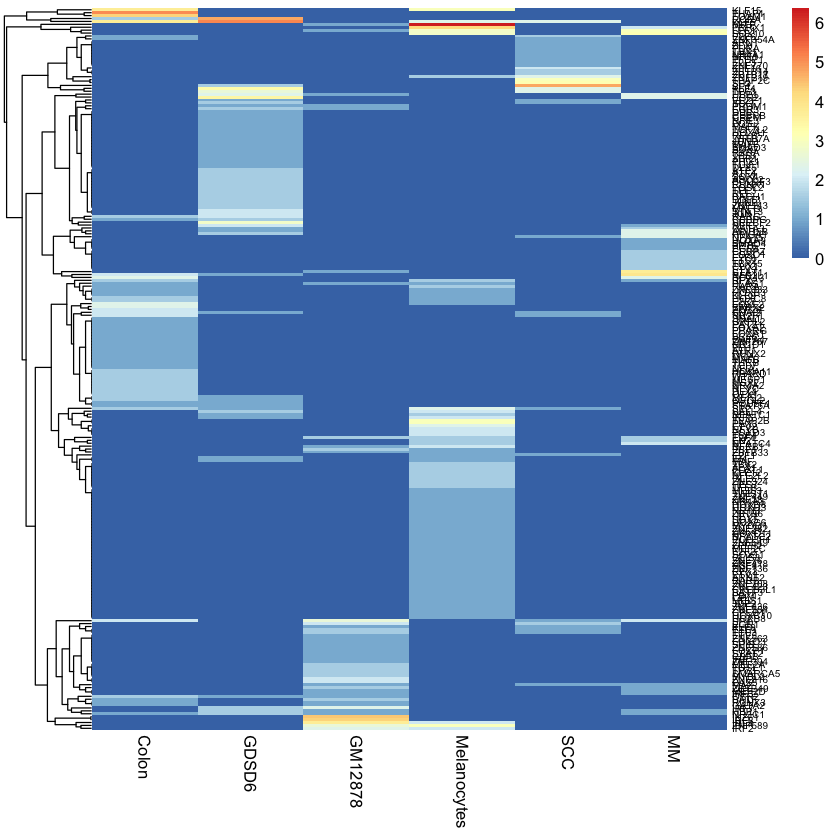

In [63]:
p = pheatmap(log2(motif_to_tissue+1), cluster_cols=F,fontsize_row=6)
paste0(save_dir, 'motif_to_tissue_log.pdf')
save_pheatmap_pdf(p, paste0(save_dir, 'motif_to_tissue_log.pdf'),width=7,height=20)

In [64]:
tf_order = rownames(motif_to_tissue)[p$tree_row[['order']]]


# 2. check RNA expression

In [65]:
rna_df_tf = read.csv(paste0(save_dir, 'rna_df_tf.csv'),row.names=1)
rna_df_tf_bin = rna_df_tf
rna_df_tf_bin[rna_df_tf>1]=1
rna_df_tf_bin[rna_df_tf<=1]=0

pdf 
  2

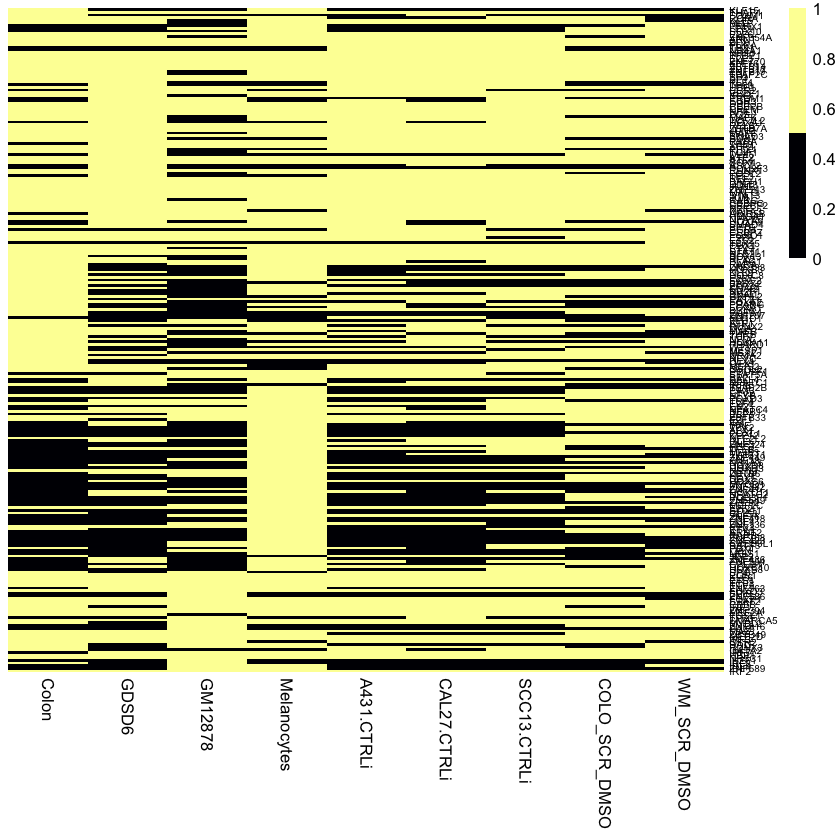

In [66]:
p_rna = pheatmap(rna_df_tf_bin[tf_order,],cluster_rows=F, cluster_cols=F,color=inferno(2),fontsize_row=6)
save_pheatmap_pdf(p_rna, paste0(save_dir, 'rna_df_tf_bin.pdf'),width=7,height=20)

In [67]:
paste0(save_dir, 'rna_df_tf_bin.pdf')

[1] "../data/processed/fig4_modelling/vocab_sum_final/rna_df_tf_bin.pdf"

# 6. add MPRA adaptors and barcodes

import in `../data/processed/fig4_modelling/vocab_sum_final/mpra_lib_seq.csv`


note that the rs sites chosen from section 4B (8E1.ipynb) are: `[RS_ECORI ,RS_BAMHI , RS_XHOI , RS_NHEI]`
also import over constants

output is `../data/processed/fig4_modelling/vocab_sum_final/mpra_oligo_df_filt.csv`

## 6A define constants and helper functions

In [3]:

# define constants
LEN_FILLER = 20
NUM_OLIGO_PER_MOTIF = 10
DESIRED_OLIGO_LENGTH = 135
MAX_OLIGO_LENGTH = 230
MAX_MOTIF_LENGTH = 63
FORWARD_PCR_PRIMER = 'ACTGGCCGCTTCACTG'
REVERSE_PCR_PRIMER = 'AGATCGGAAGAGCGTCG'
# LINKER_SPACER_v10 = 'CAGTATGCGATGCTCATGATTGTGACTGAAAGTCTATGAGTCCATTGA'
RS_ECORI = 'GAATTC' # 5'-3'
RS_BAMHI = 'GGATCC'
RS_XHOI = 'CTCGAG'
RS_NHEI = 'GCTAGC'

RS_LIST = c(RS_ECORI ,RS_BAMHI , RS_XHOI , RS_NHEI)
RS_LIST = paste(RS_LIST, collapse='|')


LETTERS=c('A', 'C', 'G', 'T')

In [4]:
# FUNCTIONS
gen_random_seq <- function (n=10, letters=LETTERS){
  # return(do.call(paste0, replicate(5, sample(letters, n, TRUE), FALSE)))
return(paste(sample(letters, n, TRUE),collapse =''))
}

gen_random_seq_restrict <- function(n=10, letters=LETTERS, rs_list = RS_LIST, max_iter = 100){
  counter = 0
  while (counter < max_iter){
    test = gen_random_seq (n, letters)
    if (!any(str_detect(test, rs_list))){
      return(test)
    }
    counter = counter + 1
    # print(c('failed',counter))
  }
}

read_fasta = function(filepath) {
  df = data.table( name = character(), motif = character())
  # print(df)
  con = file(filepath, "r")
  while ( TRUE ) {
    line = readLines(con, n = 1)
    line = str_replace_all(line, "[\r\n]" , "")
    if ( length(line) == 0 ) {
      break
    } 
    if ( str_detect(line, "^>") ) {
      n = str_split(line, "> ")[[1]][2]
    }
    else{
      m = line
      # print(c(n,m))
      df<-df %>%
        add_row(name=n,motif=m)
    }
    
  }

  close(con)
  return(df)
}


## 6B load barcodes

In [5]:
# load files
barcode_file = read.table('../data/external/barcodes_list_new.txt', header=FALSE)
# check barcodes for restriction sites within barcode and 
barcode_file_checked <- barcode_file %>%
    mutate(pass_restrict = !str_detect(as.character(V1), RS_LIST)) %>%
    filter(pass_restrict==TRUE) %>%
    mutate(barcode = as.character(V1))

# barcode_file_checked <- check_seq(barcode_file, "xbai_on")
barcode_file_checked <- filter(barcode_file_checked,pass_restrict==TRUE )
barcode_df <-  select(barcode_file_checked,barcode)

# shuffle barcodes
str(barcode_df)
barcode_df_shuf <- slice(barcode_df, sample(1:n()))

'data.frame':	399427 obs. of  1 variable:
 $ barcode: chr  "CTTAAGGCTTAGAAGAGTAT" "AAGATGGCTTAGAAGAGTAT" "GTATAGGCTTAGAAGAGTAT" "GATACGGCTTAGAAGAGTAT" ...


## 6C load sequences, 
check the edge cases and change the edges if it's bad

### pre edge manipulation

In [6]:
mpra_lib_seq = read.csv(paste0(save_dir, 'mpra_lib_seq.csv'),stringsAsFactors=F)
dim(mpra_lib_seq)
head(mpra_lib_seq)

[1] 9721    7

,X,chr,name,seq,seq_type,start,stop
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,0,chr1,BARX2::FOXF2+Colon+1+A_B,CTCAGCTCTCCCACAAGATCTCTGGGGAAGCTGGAAGAGGGCCACTAGGCCCTGTAATAACCACACTTCTTCATGGTAAACAAGAACCAGATTCCTGGGGAGTGACGCAGGCAGGAGCTCTGTGGCTGAGGCAGC,vocab,206848284,206848418
2,1,chr4,BARX2::FOXF2+Colon+2+A_B,GTGGCTCTGAGGGAATTTCAAGTAACCGTGGACTAAAGTCTTAAGAAAACAGACAACTATCACTGCAGATCTGGGCACATTGACATGTCTCATTAGGAGATTGCATCACAACACCAATGTTCAGAAACAAGGAGA,vocab,38859561,38859695
3,2,chr6,BARX2::FOXF2+Colon+3+A_B,GCCACTGCACTCCAGCCTGGTGACAGAGCGAGACTCTGTCTCAAGAAAATAAATATATATGTATGTGTGTGTGTGTATGCATGTATATAATTATATATATTATATGTAGGAGTTGGGGAGAATATGAAAACATTG,vocab,74222732,74222866
4,3,chr3,BARX2::FOXF2+Colon+4+A_B,AGTATTATGTGCTCATGGTCCCTACCCTCCAGGGTTCACAGTGTGGTTAGGGATGAAGGATGGTTACATATGTAATACAGTATTGTATGTTGTGTGGTAAAAGTGTCACAGGGGCCGGGTGCAGTGGCTCACGCC,vocab,49384615,49384749
5,4,chr10,BARX2::FOXF2+Colon+5+A_B,ATGTGGCTGCGGGGCTTTAGGAGCTGACTCTTTGGTCACGGGGAGAGAGGGAAACATAAATAATCAAATGTAAACACGAAAGACAAGGGCATGGACAAGTTCATAACAGAGAAGAGAAAAGGGAGGGTCAGCTCA,vocab,112247461,112247595
6,5,chr3,BARX2::FOXF2+Colon+6+A_B,AGTATTATGTGCTCATGGTCCCTACCCTCCAGGGTTCACAGTGTGGTTAGGGATGAAGGATGGTTACATATGTAATACAGTATTGTATGTTGTGTGGTAAAAGTGTCACAGGGGCCGGGTGCAGTGGCTCACGCC,vocab,49384615,49384749


In [7]:
# check sequences for edge cases that go bad with addition of adaptors/rs sites
mpra_lib_seq  = mpra_lib_seq%>%
    mutate(pass_restrict_seq = !str_detect(seq, RS_LIST)) %>%
    mutate(pass_restrict_fwd_seq = !str_detect(str_c(FORWARD_PCR_PRIMER,seq), RS_LIST))%>%
    mutate(pass_restrict_seq_xho = !str_detect(str_c(seq,str_sub(RS_XHOI,1,-2)), RS_LIST))
# sequences
dim(mpra_lib_seq)
dim(distinct(select(mpra_lib_seq,name)))
# seq that aren't solvable
dim(distinct(select(filter(mpra_lib_seq, pass_restrict_seq==TRUE),name)))
# seq that aren't solvable b/c of adaptor and Xho addition (the ends of the seq)
dim(distinct(select(filter(mpra_lib_seq, pass_restrict_fwd_seq==TRUE),name)))
dim(distinct(select(filter(mpra_lib_seq, pass_restrict_seq_xho==TRUE),name)))


# filter(mpra_lib_seq, pass_restrict_fwd_seq==FALSE)
# filter(mpra_lib_seq, pass_restrict_seq_xho==FALSE)

[1] 9721   10

[1] 9721    1

[1] 9721    1

[1] 9707    1

[1] 9705    1

In [8]:
# ## testing
# seq = 'AATTCTGATGAATGCATAAGTTAAACATTCAAGCTGGAGAAACTGGTGCCTGAGTACAAGGCCTGGAATGTGAAAACAAATACATTAAGACCTCGCCTGGACTTTCTCAGACCCTAACATCTGATCGAAGGCATT'
# seq
# paste0('CA',str_sub(seq, 3,-1))
# paste0(str_sub(seq, 1,-2),'C')

### post edge manipulation

- for things that miss the fwd_seq filter, change the first two letters to CA
- for things that miss the seq_xho filter, change the last letters to T 

keep modifying until something works

In [9]:

mpra_lib_seq = mpra_lib_seq%>%
    mutate(seq = if_else(pass_restrict_fwd_seq==TRUE, seq, paste0('CA',str_sub(seq, 3,-1))))%>%
    mutate(seq = if_else(pass_restrict_seq_xho==TRUE, seq, paste0(str_sub(seq, 1,-2),'C')))


In [10]:
# check sequences for edge cases that go bad with addition of adaptors/rs sites
mpra_lib_seq  = mpra_lib_seq%>%
    mutate(pass_restrict_seq = !str_detect(seq, RS_LIST)) %>%
    mutate(pass_restrict_fwd_seq = !str_detect(str_c(FORWARD_PCR_PRIMER,seq), RS_LIST))%>%
    mutate(pass_restrict_seq_xho = !str_detect(str_c(seq,str_sub(RS_XHOI,1,-2)), RS_LIST))
# sequences
dim(mpra_lib_seq)
dim(distinct(select(mpra_lib_seq,name)))
# seq that aren't solvable
dim(distinct(select(filter(mpra_lib_seq, pass_restrict_seq==TRUE),name)))
# seq that aren't solvable b/c of adaptor and Xho addition (the ends of the seq)
dim(distinct(select(filter(mpra_lib_seq, pass_restrict_fwd_seq==TRUE),name)))
dim(distinct(select(filter(mpra_lib_seq, pass_restrict_seq_xho==TRUE),name)))



[1] 9721   10

[1] 9721    1

[1] 9721    1

[1] 9721    1

[1] 9721    1

## 6D make lib --> oligo (20x for barcode adding)

In [11]:
# making oligo sequences (try 20 first)
oligo_df <- mpra_lib_seq %>%
   group_by(name,seq, seq_type) %>% 
     expand(count = seq(1:as.numeric(NUM_OLIGO_PER_MOTIF*2))) %>% 
   ungroup()

In [12]:
# check if adding the FWD PRIMER +/- the 
oligo_df <- oligo_df %>%
  mutate(id = str_c(name,count, sep='.')) %>%
  mutate(pass_restrict_seq = !str_detect(seq, RS_LIST)) %>%
  mutate(pass_restrict_fwd_seq = !str_detect(str_c(FORWARD_PCR_PRIMER,seq), RS_LIST))%>%
  mutate(pass_restrict_seq_xho = !str_detect(str_c(seq,str_sub(RS_XHOI,1,-2)), RS_LIST))


In [13]:
# sequences
dim(oligo_df)
dim(distinct(select(oligo_df,name)))
# seq that aren't solvable
dim(distinct(select(filter(oligo_df, pass_restrict_seq==TRUE),name)))
# seq that aren't solvable b/c of adaptor and Xho addition (the ends of the seq)
dim(distinct(select(filter(oligo_df, pass_restrict_fwd_seq==TRUE),name)))
dim(distinct(select(filter(oligo_df, pass_restrict_seq_xho==TRUE),name)))


[1] 194420      8

[1] 9721    1

[1] 9721    1

[1] 9721    1

[1] 9721    1

as seen from the above edge manipulation section, all sequences are good

### adding barcodes to oligo library

In [14]:
oligo_df['barcode'] = barcode_df_shuf[1:nrow(oligo_df),]

In [15]:
colnames(oligo_df)
dim(oligo_df)
head(oligo_df)
# unique(oligo_df$name)[1:40]

[1] "name"                  "seq"                   "seq_type"             
[4] "count"                 "id"                    "pass_restrict_seq"    
[7] "pass_restrict_fwd_seq" "pass_restrict_seq_xho" "barcode"

[1] 194420      9

name,seq,seq_type,count,id,pass_restrict_seq,pass_restrict_fwd_seq,pass_restrict_seq_xho,barcode
<chr>,<chr>,<chr>,<int>,<chr>,<lgl>,<lgl>,<lgl>,<chr>
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,1,ABCF3.1,TRUE,TRUE,TRUE,AAGATTAATCGGAGGAGTTG
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,2,ABCF3.2,TRUE,TRUE,TRUE,AGCGTCTTAGCTGTCGTCTA
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,3,ABCF3.3,TRUE,TRUE,TRUE,CGTCCGACGCAAGCTATTGC
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,4,ABCF3.4,TRUE,TRUE,TRUE,GAAGTACTCTCCTGCGAGGA
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,5,ABCF3.5,TRUE,TRUE,TRUE,TGAGATCCAACCAAGGTTGC
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,6,ABCF3.6,TRUE,TRUE,TRUE,GAAGTCCGATCTGGATATGG


### adding all the parts of sequences together

In [16]:
oligo_df_annon = oligo_df %>%
  mutate(len_seq = str_length(seq)) %>%
  mutate(len_filler = LEN_FILLER)%>% #max(len_motif_combo) - len_motif_combo) %>%
  group_by(1:n()) %>%
  mutate(filler = gen_random_seq_restrict(n= len_filler))%>%
  ungroup()%>%
  mutate(filler_check = str_length(filler)==len_filler)%>%
  mutate(oligo = str_c(FORWARD_PCR_PRIMER, seq, RS_XHOI, filler, RS_NHEI, barcode, REVERSE_PCR_PRIMER))%>%
  mutate(len_oligo = str_length(oligo))%>%
  mutate(pass_restrict_ECORI = !str_detect(oligo, RS_ECORI)) %>%
  mutate(pass_restrict_BAMHI = !str_detect(oligo, RS_BAMHI)) %>%
  mutate(pass_restrict_XHOI = str_count(oligo, RS_XHOI) == 1) %>%
  mutate(pass_restrict_NHEI = str_count(oligo, RS_NHEI) == 1) %>%
  mutate(pass_all =filler_check& pass_restrict_ECORI & pass_restrict_BAMHI& pass_restrict_XHOI& pass_restrict_NHEI)

In [17]:
# how many errors
nrow(oligo_df_annon)
nrow(distinct(select(filter(oligo_df_annon, pass_all==FALSE),id)))
nrow(distinct(select(filter(oligo_df_annon, pass_restrict_ECORI==FALSE),id)))
nrow(distinct(select(filter(oligo_df_annon, pass_restrict_BAMHI==FALSE),id)))
nrow(distinct(select(filter(oligo_df_annon, pass_restrict_XHOI==FALSE),id)))
nrow(distinct(select(filter(oligo_df_annon, pass_restrict_NHEI==FALSE),id)))


[1] 194420

[1] 725

[1] 186

[1] 197

[1] 168

[1] 174

### filter out the bad rs ones and saving


In [18]:
oligo_df_filt <- oligo_df_annon %>%
   filter(pass_all==TRUE)%>%
   group_by(name, seq) %>%
   do(sample_n(.,NUM_OLIGO_PER_MOTIF)) %>% 
   mutate(count =  1:n()) %>%
   ungroup()%>%
  mutate(id = str_c(name,count, sep='.'))%>%
 # recheck
  mutate(pass_restrict_ECORI = !str_detect(oligo, RS_ECORI)) %>%
  mutate(pass_restrict_BAMHI = !str_detect(oligo, RS_BAMHI)) %>%
  mutate(pass_restrict_XHOI = str_count(oligo, RS_XHOI) == 1) %>%
  mutate(pass_restrict_NHEI = str_count(oligo, RS_NHEI) == 1) %>%
  mutate(pass_all = pass_restrict_ECORI & pass_restrict_BAMHI& pass_restrict_XHOI& pass_restrict_NHEI)

In [19]:
# number of fails
nrow(distinct(select(filter(oligo_df_filt, pass_all==FALSE),id))) # should be 0
#number of distinct barcodes
summarize(oligo_df_filt,n_distinct( barcode)) # should be equal to num motifs * 10

[1] 0

n_distinct(barcode)
<int>
97210


In [20]:
colnames(oligo_df_filt)
dim(oligo_df_filt)
head(oligo_df_filt)


[1] "name"                  "seq"                   "seq_type"             
 [4] "count"                 "id"                    "pass_restrict_seq"    
 [7] "pass_restrict_fwd_seq" "pass_restrict_seq_xho" "barcode"              
[10] "len_seq"               "len_filler"            "1:n()"                
[13] "filler"                "filler_check"          "oligo"                
[16] "len_oligo"             "pass_restrict_ECORI"   "pass_restrict_BAMHI"  
[19] "pass_restrict_XHOI"    "pass_restrict_NHEI"    "pass_all"

[1] 97210    21

name,seq,seq_type,count,id,pass_restrict_seq,pass_restrict_fwd_seq,pass_restrict_seq_xho,barcode,len_seq,⋯,1:n(),filler,filler_check,oligo,len_oligo,pass_restrict_ECORI,pass_restrict_BAMHI,pass_restrict_XHOI,pass_restrict_NHEI,pass_all
<chr>,<chr>,<chr>,<int>,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<int>,⋯,<int>,<chr>,<lgl>,<chr>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,1,ABCF3.1,TRUE,TRUE,TRUE,GACCGGAGTAGGTTAGGTTA,136,⋯,8,CCGCCATTGTCTCGGGCGAA,TRUE,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCACTCGAGCCGCCATTGTCTCGGGCGAAGCTAGCGACCGGAGTAGGTTAGGTTAAGATCGGAAGAGCGTCG,221,TRUE,TRUE,TRUE,TRUE,TRUE
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,2,ABCF3.2,TRUE,TRUE,TRUE,GCTGGCGAATATAAGAGTAT,136,⋯,14,GCCCTATTATATGTGCGTCC,TRUE,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCACTCGAGGCCCTATTATATGTGCGTCCGCTAGCGCTGGCGAATATAAGAGTATAGATCGGAAGAGCGTCG,221,TRUE,TRUE,TRUE,TRUE,TRUE
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,3,ABCF3.3,TRUE,TRUE,TRUE,TGAGATCCAACCAAGGTTGC,136,⋯,5,ACAAGGTAGGAGGGGCAGAG,TRUE,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCACTCGAGACAAGGTAGGAGGGGCAGAGGCTAGCTGAGATCCAACCAAGGTTGCAGATCGGAAGAGCGTCG,221,TRUE,TRUE,TRUE,TRUE,TRUE
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,4,ABCF3.4,TRUE,TRUE,TRUE,AAGATTAATCGGAGGAGTTG,136,⋯,1,CCTAAAATATGGACTTACCG,TRUE,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCACTCGAGCCTAAAATATGGACTTACCGGCTAGCAAGATTAATCGGAGGAGTTGAGATCGGAAGAGCGTCG,221,TRUE,TRUE,TRUE,TRUE,TRUE
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,5,ABCF3.5,TRUE,TRUE,TRUE,GAAGTACTCTCCTGCGAGGA,136,⋯,4,AGGACCTCCGTTGGCAATTC,TRUE,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCACTCGAGAGGACCTCCGTTGGCAATTCGCTAGCGAAGTACTCTCCTGCGAGGAAGATCGGAAGAGCGTCG,221,TRUE,TRUE,TRUE,TRUE,TRUE
ABCF3,ACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCA,pos,6,ABCF3.6,TRUE,TRUE,TRUE,ATAGGTTGGATAGTCGTCTA,136,⋯,19,AATCCGCGCCCGCGATCGTT,TRUE,ACTGGCCGCTTCACTGACCTTGAGCTCCCAGCCTTTGCCCCACCCCTCGCTCCCGGAACTCCACCTCCCAGAAGGCAGCGAGAACCGCACATGTGGCTAATCTTTCAGCGGAAAAGGTGTCGCGCACGCGCAGAGAGCGCGGCTCCGGCGCACTCGAGAATCCGCGCCCGCGATCGTTGCTAGCATAGGTTGGATAGTCGTCTAAGATCGGAAGAGCGTCG,221,TRUE,TRUE,TRUE,TRUE,TRUE


In [21]:
nchar(oligo_df_filt$oligo[1])

[1] 221

oligos are 221 bp long

In [22]:
write.csv(oligo_df_filt, file=paste0(save_dir,'mpra_oligo_df_filt.csv'))
oligo_df_filt = read.csv(paste0(save_dir,'mpra_oligo_df_filt.csv'),stringsAsFactors=F)

## 6E create submission worthy txt files
- `../data/processed/fig4_modelling/vocab_sum_final/mpra_oligo_df_final.txt` - with columns: name, seq_type, id, oligo, seq, filler, barcode
- `../data/processed/fig4_modelling/vocab_sum_final/mpra_oligo_df_final_SUBMIT.txt` - with columns: id, oligo


In [23]:
write.table(select(oligo_df_filt, name, seq_type, id, oligo, seq, filler, barcode), file=paste0(save_dir,'mpra_oligo_df_final.txt'),sep='\t', quote = FALSE,row.names=FALSE)
write.table(select(oligo_df_filt,  id, oligo), file=paste0(save_dir,'mpra_oligo_df_final_SUBMIT.txt'),sep='\t', quote = FALSE,row.names=FALSE)
